# Quantifying uncertainty in 2D seismic wave propagation
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" href="https://github.com/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In [6]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

Cloning into 'fwi'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 78 (delta 23), reused 70 (delta 21), pack-reused 3
Unpacking objects: 100% (78/78), done.
/content/fwi/fwi


## Import libraries

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

from func.propagation import prop2d, defmodel
# from func.inversion import gradiant
# from func.velocity_model import check_model
from func.propagation_tf import simulate_obs

In [ ]:
import sys, importlib
# importlib.reload(sys.modules['med.func.inversion'])
importlib.reload(sys.modules['func.propagation_tf'])

<module 'func.propagation_tf' from '/home/medicinely/med/fwi/func/propagation_tf.py'>

## Calcualte d_obs

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  28 28 235
Number of receivers: 10


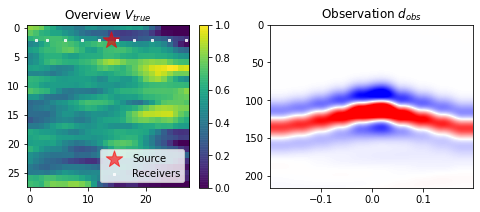

In [11]:
# Import true model and observation
import pickle
filename = './data/v_ref'
infile = open(filename, 'rb')
v_ref = pickle.load(infile)
infile.close()

filename = './data/d_obs'
infile = open(filename, 'rb')
d_obs = pickle.load(infile)
infile.close()

# v_ref = gaussian2d(ranges=[nz//2,nx//5],variance=200,
#                    nx=[nz,nx],param=1,mean=2500) # to generate new model only

# Initialize the model axis az, ax, at
nz,nx,nt = 28,28,235
vmin,vmax=2000,3000
az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=[nz//10], ixsrc=[nx//2],  # define source coordinates z, x
                      ext=10)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
nrec = 10 # number of receivers per well
receivers_width = np.linspace(1,nx-1,num=nrec, endpoint=True, dtype=int)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(v_ref)
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.colorbar()
plt.title("Overview $V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

################# New observation ################
# # Simulate real observation
# p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device=device)
# print("shape of p(z,x,t) =", p.shape)
# d_obs = p[zxrec[0], zxrec[1], :]

## Functions - tf 2D propagation

## $Gradiant  = \frac{\mathrm{d} J}{\mathrm{d} v}$

Total time 00h 00m 49s
J = 77.9538269043
gradient shape: (28, 28)


Text(0.5, 1.0, 'Gradient of initial V')

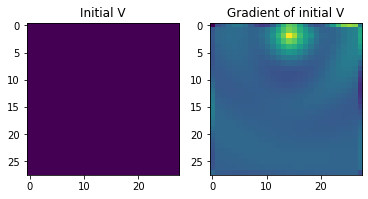

In [14]:
v = tf.Variable(tf.convert_to_tensor(np.zeros([nz, nx]) + 2500,dtype="float32"))
with tf.GradientTape() as tape:
	tape.watch(v)
	start = time.time()
	d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
	print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))
	# Calculate loss "J"
	loss = .5 * tf.reduce_sum((d - d_obs)**2)
	print("J = %.10f" % loss.numpy())
g = tape.gradient(loss, v)
print("gradient shape:", g.shape)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(v)
plt.title("Initial V")
plt.subplot(1,2,2)
plt.imshow(g)
plt.title("Gradient of initial V")

## Sampling (latent space)

In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [16]:
latent_dim = 40
img_width, img_height = 28,28
# acfunc = "tanh" #relu
# acfunc2 = "tanh" #sigmoid
acfunc = "relu" 
acfunc2 = "sigmoid" 

encoder_inputs = keras.Input(shape=(img_width, img_height, 1))
x = layers.Conv2D(32, 3, activation=acfunc, strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation=acfunc, strides=2, padding="same")(x)
conv_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(16, activation=acfunc)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation=acfunc)(latent_inputs)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation=acfunc, strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation=acfunc, strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation=acfunc2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              128576    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Train the VAE

Epoch 1/500
1/1 [==============================] - 0s 89ms/step - loss: 353.2471 - reconstruction_loss: 353.2471 - kl_loss: 2.6822e-06
Epoch 2/500
1/1 [==============================] - 0s 59ms/step - loss: 355.1100 - reconstruction_loss: 355.1100 - kl_loss: 2.7210e-05
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 353.3117 - reconstruction_loss: 353.3116 - kl_loss: 4.7952e-05
Epoch 4/500
1/1 [==============================] - 0s 47ms/step - loss: 353.8372 - reconstruction_loss: 353.8372 - kl_loss: 7.5489e-05
Epoch 5/500
1/1 [==============================] - 0s 33ms/step - loss: 354.2121 - reconstruction_loss: 354.2120 - kl_loss: 1.0207e-04
Epoch 6/500
1/1 [==============================] - 0s 32ms/step - loss: 353.9726 - reconstruction_loss: 353.9725 - kl_loss: 1.2755e-04
Epoch 7/500
1/1 [==============================] - 0s 34ms/step - loss: 353.3479 - reconstruction_loss: 353.3477 - kl_loss: 1.7026e-04
Epoch 8/500
1/1 [==============================] - 0s 3

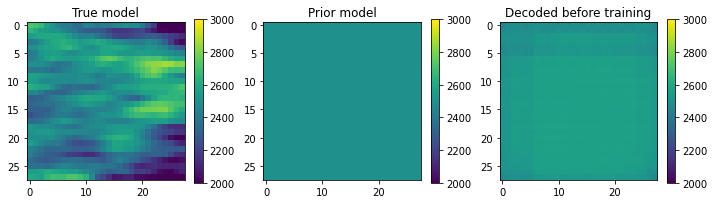

In [32]:
# Set prior velocity field (28,28)
prior = np.zeros([nz, nx]) + 2500
# prior = v_ref
prior = prior/3000
prior = prior.reshape(1,img_width,img_height,1)

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 1*kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(prior, epochs=500, batch_size=1, verbose=1)

# Decode prior to latent prior distribution
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(mu).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())


plt.figure(figsize=(12,3))
# output image
plt.subplot(1,3,1)
print("Reference mean:",v_ref.mean())
plt.imshow(v_ref,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("True model")

# Input image
plt.subplot(1,3,2)
print("Input mean:",input.mean())
plt.imshow(input,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("Prior model")

# output image
plt.subplot(1,3,3)
print("Output mean:",output.mean())
plt.imshow(output,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("Decoded before training")
plt.show()

## Define the VAE as a `Model` with a custom `train_step`

In [35]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        # reconstruction_loss = tf.reduce_mean(
        #     tf.reduce_sum(
        #         keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        #     )
        # )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        """"""
        v = 3000 * tf.reshape(reconstruction,[nz,nx])
        d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
        reconstruction_loss = .5 * tf.reduce_sum((d - d_obs)**2)
        """"""
        total_loss = reconstruction_loss + 0*kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

In [ ]:
# Start training
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae = VAE(encoder, decoder)
vae.compile(optimizer=opt, run_eagerly=True)
vae.fit(prior, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
1/1 [==============================] - 51s 51s/step - loss: 77.7455 - reconstruction_loss: 77.7455 - kl_loss: 3.8743e-07
Epoch 2/50


## Generate new image

1/1 [==============================] - 0s 14ms/step
Average loss: 3.2208466821787307
Input mean: 2500.0


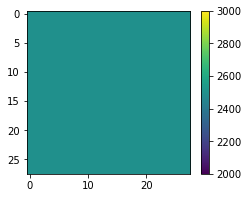

Output mean: 2501.5986


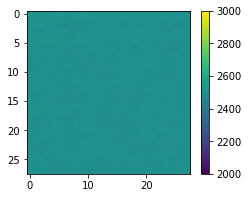

In [44]:
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(z).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())
# Input image
plt.figure(figsize=(4,3))
# plt.subplot(1,2,1)
print("Input mean:",input.mean())
plt.imshow(input,vmin=2000,vmax=3000)
plt.colorbar()
plt.show()
# output image
plt.figure(figsize=(4,3))
# plt.subplot(1,2,2)
print("Output mean:",output.mean())
plt.imshow(output,vmin=2000,vmax=3000)
plt.colorbar()
plt.show()

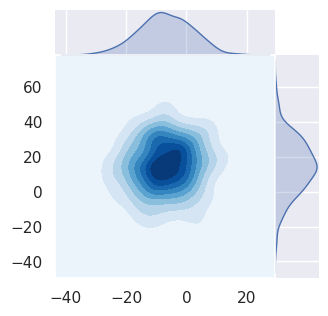

In [ ]:
def show_posterior(mu,sig):
  mean = [mu[0,0], mu[0,1]]
  cov = [[sig[0,0]**2, 0], [0, mu[0,1]**2]]

  x, y = np.random.multivariate_normal(mean, cov, 500).T
  # sns.set_style("darkgrid")
  ax = sns.jointplot(x=x,y=y,kind="kde",space=0,fill=True,
                    thresh=0,cmap='Blues',joint_kws={'alpha': 1})
  ax.fig.set_size_inches(3,3)

show_posterior(mu,sig)